__Project Overview:__

The goal of this project is to perform a comprehensive analysis of the tumor microenvironment of three separate breast cancer subtypes - HER2+, ER+, and TNBC - from scRNA-seq data. The overall aim is to identify cellular biomarkers that could provide potential diagnostic insight for differentiating between breast cancer subtypes. 

This analysis consists of three stages defined by preprocessing (dataset loading, QC, normalization, highly variable feature selection, and scaling), processing (PCA, clustering, differentially expressed feature extraction, and UMAP plotting), and postprocessing (cell-specific UMAP labelling and plotting), all of which are detailed throughout this notebook. 

The dataset used in this project can be found [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE176078) and consists of scRNA-seq data from 26 combined HER2+, ER+, and TNBC-specific patient samples. The supplementary file *GSE176078_Wu_etal_2021_BRCA_scRNASeq.tar.gz* can be found at the bottom of the GEO page and is the basis for this analysis.

This analysis was guided and inspired by the work of [Ido Nofech-Mozes et al.](https://www.nature.com/articles/s41467-023-37353-8) and the [Seurat - Guided Clustering Tutorial](https://satijalab.org/seurat/articles/pbmc3k_tutorial) developed by Rahul Satija, Satija Lab, and Collaborators.

__Packages:__

In [3]:
import sys
import os
sys.path.append(os.path.abspath('../analysis'))

import preprocessing
import processing
import postprocessing
import plots

__Parameters:__

The following parameters are set to their default values, as found in the params.yaml file in the parameters directory. They can be further adjusted as needed.

In [4]:
#raw_data:
raw_gene_data_path = "../data/Wu_etal_2021_BRCA_scRNASeq/count_matrix_genes.tsv"
raw_metadata_path = "../data/Wu_etal_2021_BRCA_scRNASeq/metadata.csv"
raw_barcodes_path = "../data/Wu_etal_2021_BRCA_scRNASeq/count_matrix_barcodes.tsv"
raw_mtx_path = "../data/Wu_etal_2021_BRCA_scRNASeq/count_matrix_sparse.mtx"

#updated_data:
updated_data_path = "../data/"

#QC: #quality control/preprocessing
n_feature_min = 200
n_feature_max = 5000 
n_count_min = 500
n_count_max = 20000 
percent_mt_max = 15 

#features: #feature selection
n_HVFs = 2000 #number of features chosen for analysis
n_feats = 20 #top n features to be displayed

#PCA:
n_vars = 20 #number of genes/features per PC
pc_range = [1,2] #range of PCs to be displayed

#clustering:
n_neighbors = 15 #number of neighbors considered for each cell during graph construction
n_pcs = 11 #number of PCs chosen for clustering - determined by elbow plot
resolution = 0.5 #coarseness of clustering - larger number = more clusters

#UMAP:
min_dist = 0.5 #distance between embedded points - smaller values cause more clustering
spread = 1 #scale of embedded points

#DEF:
n_genes = 10 #number of differnetially expressed markers per PC

#plots:
display_qc_metrics = True
display_UMAP_unlabeled = True

------------------------------------------------------------------------------------------------------------------------------

__1) Preprocessing:__

The following steps detail preprocessing, which is divided into four primary components.

The raw dataset is loaded in the contained .tsv and metadata files are reorganized so that they align with standard scanpy format in orde to continue with the rest of the analysis. This is then followed by read filtering and quality control, in which samples/cell metrics that do not align with the predefined parameters (such as max gene count, min RNA count, and percentage of mitochondrial DNA found) are excluded from subsequent analyses. 

The resulting data is then normalized via counts per million (CPM) normalization, log transformed, and then only the top 2000 highly variable features (HVGs) are identified and subsetted to be further analyzed. These resulting HVGs are then scaled via linear transformation in order to prepare the data for step 2: processing.

__A) Load in raw dataset__:

In [5]:
#load in gene data
print("Reading sample data...")
adata = preprocessing.load_gene_data(raw_gene_data_path, raw_barcodes_path, raw_mtx_path, updated_data_path)

Reading sample data...


__B) Load in raw metadata:__

Also displays relevant plots to determine distribution of raw data for filtering/QC.

Reading metadata...


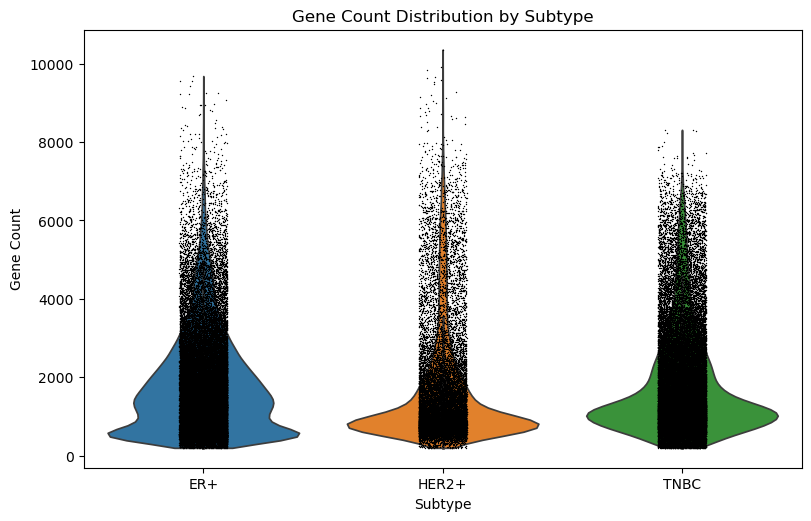

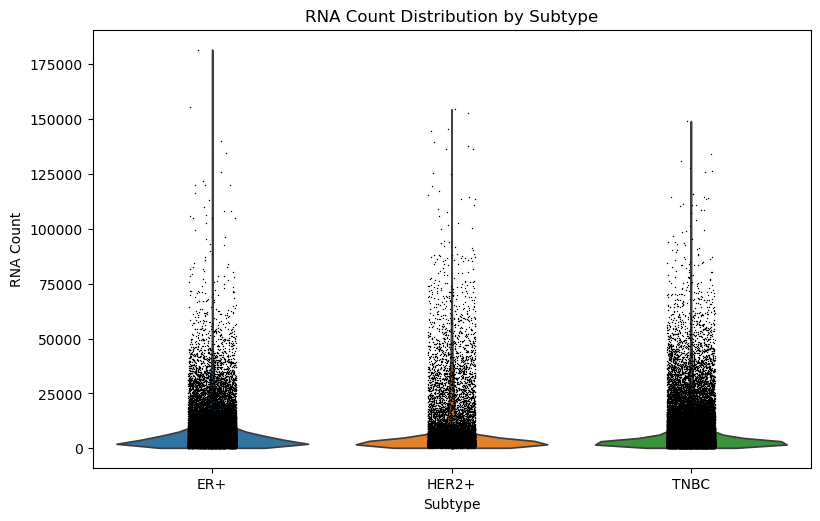

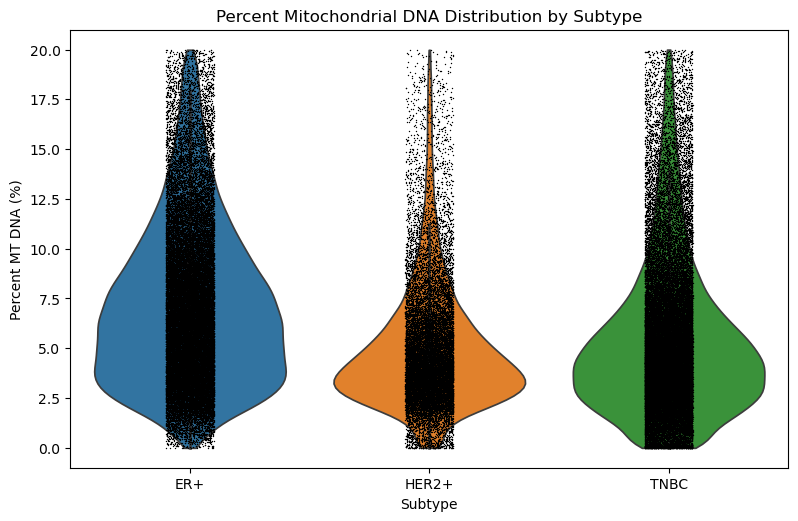

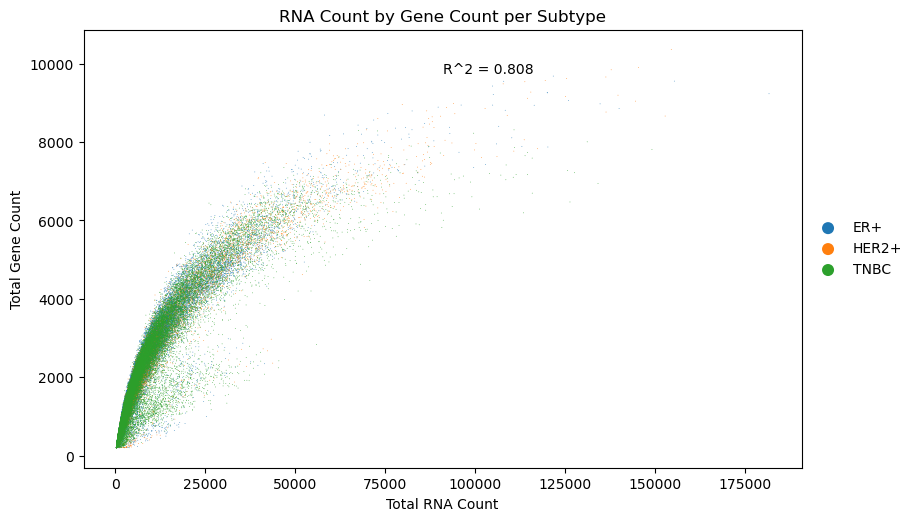

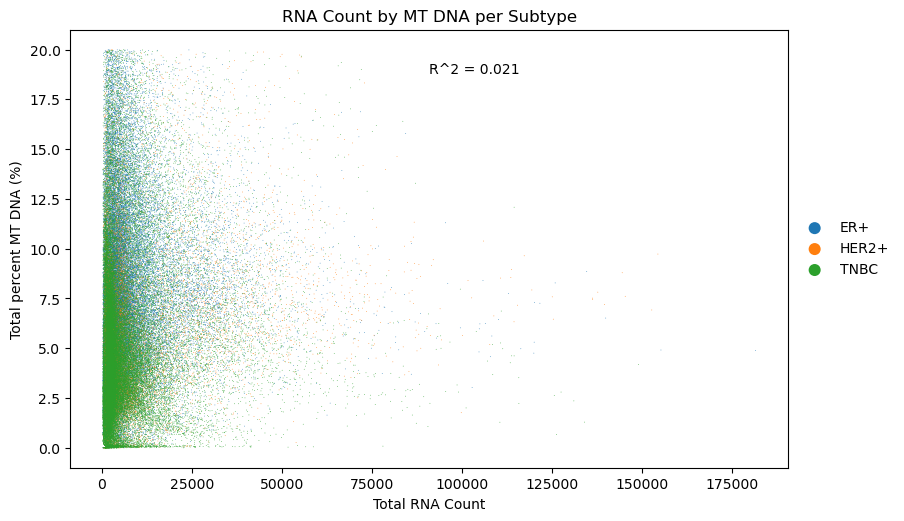

In [ ]:
#load in metadata
print("Reading metadata...")
metadata = preprocessing.load_metadata(raw_metadata_path, updated_data_path, adata) #Note: cell_id not defined, need to change to 'orig.ident'

#plot subtype qc metrics
if display_qc_metrics == True:
    plots.plot_qc_metrics(adata)

The plots above help identify the distribution of RNA count, gene (feature) count, and percent of mitochondrial DNA present per cell across all three breast cancer subtypes. For quality control and sample filtering, minimum and maximum thresholds of each of these metrics are set to ensure that only high-quality samples are being considered for the rest of the analysis.

For RNA count, a min of 500 and max of 20,000 is set. These values were determined by plotting a box and whisker plot for each subtype, and excluding all cells that fall outside of the 'whiskers', which would be classified as outliers statistically. Biologically, cells that are considered outliers are most likely either cell doublets which involve 2+ cells being captured in a single droplet during sequencing, or a case in which no cells were captured by a single droplet and thus have 0 RNA count. Additionally, setting a minimum RNA count of 500 helps exclude dead or dying cells that may provide insufficient data for later analysis. This same reasoning also applies to the minimum and maximum values set for gene count. 

Only a maxium threshold for percent mitochondrial DNA is defined, since all cells that fall below 15% in this case are considered high-quality cells. For a typical scRNA-Seq analysis, max percent mitochdonrial DNA can range anywhere from 10-20% depending on the size of the dataset. Cells that exceed this range are often excluded from analysis due to the high probability that the cell is dying or undergoing some form of denaturation that affects the quality of the cell.

__C) Run Quality Control and normalization:__

Due to the significant differences in cells available for HER2+ samples compared to TNBC and ER+ samples, normalizations is performed using counts per million (CPM) normalization. This enables us to account for the different number of cells which also equates to a disparity in sequencing depth across the subtypes as a whole. Applying CPM normalization prevents bias when comparing gene expression profiles later on.

In [44]:
#perform qc and normalization
print("Filtering samples per QC metrics...")
adata, metadata = preprocessing.run_qc_norm(adata, metadata, n_feature_min, n_feature_max, n_count_min, n_count_max, percent_mt_max)

Filtering samples per QC metrics...
Number of TNBC samples pass QC (total, %): 36667 86.25
Number of HER2+ samples pass QC (total, %): 17367 89.93
Number of ER+ samples pass QC (total, %): 32993 86.28
Normalizing data by CPM...


__D) Log transform data, select highly variable features, scale data:__

Identifying highly variable features...


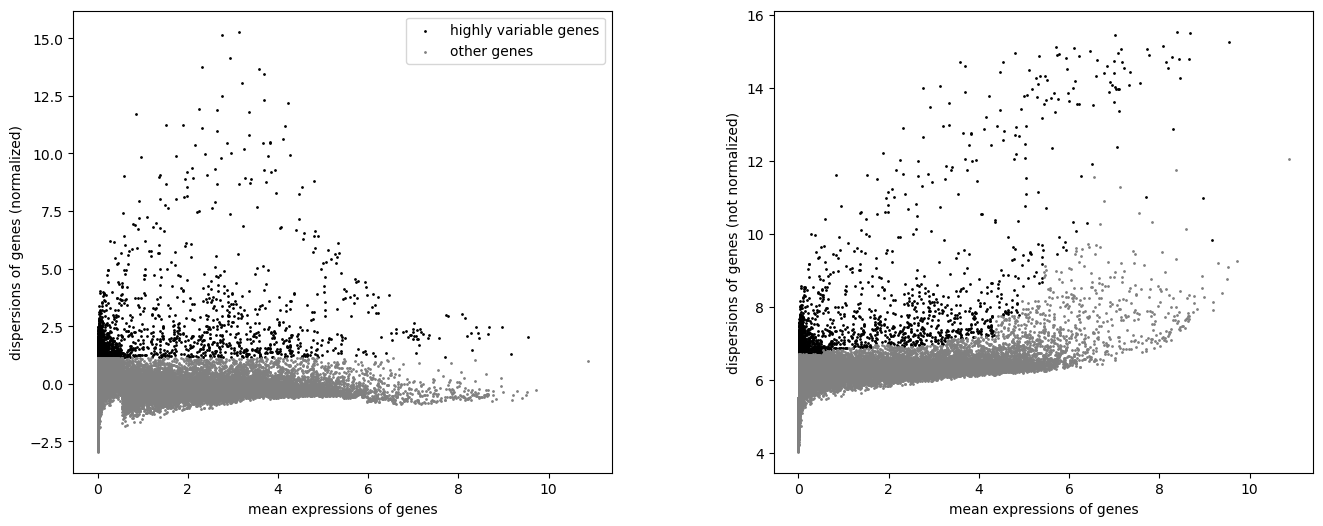

Top 20 highly variable features:
                 gene_ids  highly_variable     means  dispersions  \
IGKV6-21        Gene_2714             True  3.137332    14.048645   
IGKV6D-21      Gene_27021             True  2.751577    13.976608   
IGLV7-43       Gene_20454             True  2.926898    13.472722   
DCD            Gene_22676             True  2.322459    12.891103   
IGHV2-70       Gene_15051             True  3.579914    14.705333   
IGKV1D-13       Gene_2728             True  3.691536    14.580012   
IGHD           Gene_15007             True  3.205406    12.940271   
IGKV2D-30      Gene_22569             True  2.763372    12.647748   
IGHV3-13       Gene_15022             True  3.698938    13.886918   
IGLV10-54      Gene_27236             True  4.217774    13.778639   
IGKV1OR2-108   Gene_21217             True  2.256885    12.030715   
IGKV1D-12      Gene_21213             True  2.656656    12.002710   
IGLV4-60       Gene_20443             True  3.348377    13.580855   
R

In [45]:
#identify (and display) highly variable features
print("Identifying highly variable features...")
adata = preprocessing.select_feats(adata, n_HVFs, n_feats)

The most highly variable features are shown above and placed in descending order by the 'dispersions' column, which represents the variance of gene expression normalized by the mean expression of a gene across all cells. From the top 20 features shown above, the majority of them include IGK, IGL, and IGH markers, which represent the immunoglobulin chains and variable regions that make up antibodies. Due to the nature of our data being derived from breast cancer subtypes, the presence of so many antibody-encoding genes makes sense, and can further help us identify specific clusters of cells preent in this dataset later in the analysis.

__2) Processing:__

The following steps detail processing, which is divided into three primary components.

The previously identified highly variable features that have been scaled are now run through Principal Component Analysis (PCA), a method of linear dimensionality reduction that reduces the dimensionality of our analysis matrix from 2 thousand genes, down to just a few defining principal components (PCs). This enables us to better identify what genes/markers are providing the most expression variation between cells in our dataset.

This is followed by the application of K-Nearest Neighbor (KNN), an algorithm that clusters cells closely together based on their gene expression patterns. KNN generates a 'neighborhood graph', which represents all of the cells in our dataset by their gene expression profiles, placing cells with similar profiles close by in euclidean distance, and cells that are dissimilar farther apart. These 'neighborhoods' of cells are then grouped together, or clustered, using the leiden algorithm, which aims to solidify the connections between cells based on these gene expression profiles and visualize them together as a single cluster.

With defined clusters, we then perform an analysis to identify differentially expressed features/genes (DEFs) that provide the most heterogeneity to our dataset. They enable us to identify specific markers that are statistically significantly expressed across clusters/PCs, and serves as a crucial step for later labeling these clusters with specific cell types based on these identified canonical markers.

__A) Run PCA:__

Performing linear dimensionality reduction (PCA)...


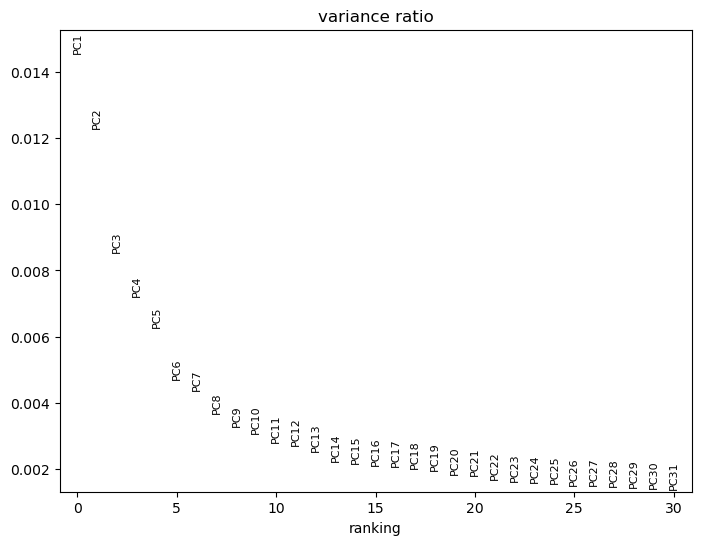

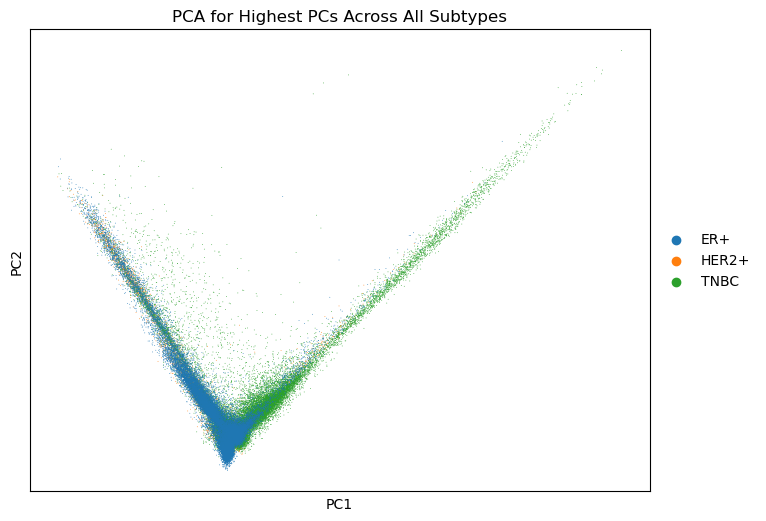

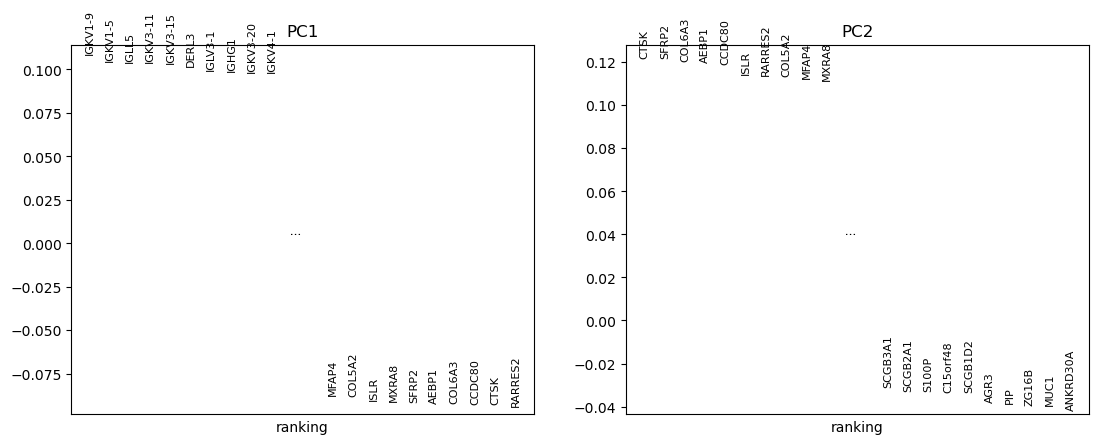

In [46]:
#run PCA
print("Performing linear dimensionality reduction (PCA)...")
adata = processing.run_pca(adata, n_vars, pc_range)

The first plot shown above, labeled 'variance ratio', represents the principal component elbow plot and helps us to identify the PCs that contain significant markers that contribute the most to the variability in the dataset. By identifying where the 'bend' or 'elbow' in the curve of the plot is, we can ensure that the PCs we take into differnetial feature expression analysis compose of the majority of the variation of our data. In this analysis, the parameter 'n_pcs' is set to 11 to capture only the first 11 PCs downstream.

The second/middle plot depicts a PCA between the top 2 PCs in our dataset, and is categorized by cancer subtype. In this plot, we can clearly see the separation of cells present in ER+ and TNBC samples, indicating a distinct difference in gene expression between the cells that are present in these two subtypes. In this plot, cells that are located further away from each other have significantly different gene expression profiles, whereas cells that are close together have similar profiles. From this plot, it also appears that HER2+ cells share similar expression profiles compared to ER+.

Finally, we visualize the specific markers that make up the top 2 PCs responsible for composing the PCA plot. In PC1 for example, we can see that markers such as IGKV1-9 and IGKV1-5 are overexpressed at statistically significant levels, whereas markers such as MFAP4 and COL5A2 are underexpressed. These markers will serve as especially helpful for identifying each cluster of cells that are identified in the next step.

__B) Clustering:__

Clustering data and creating UMAP...


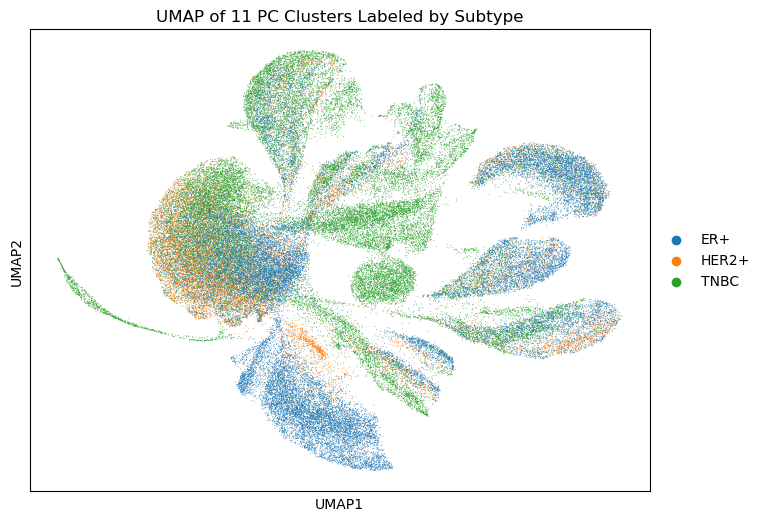

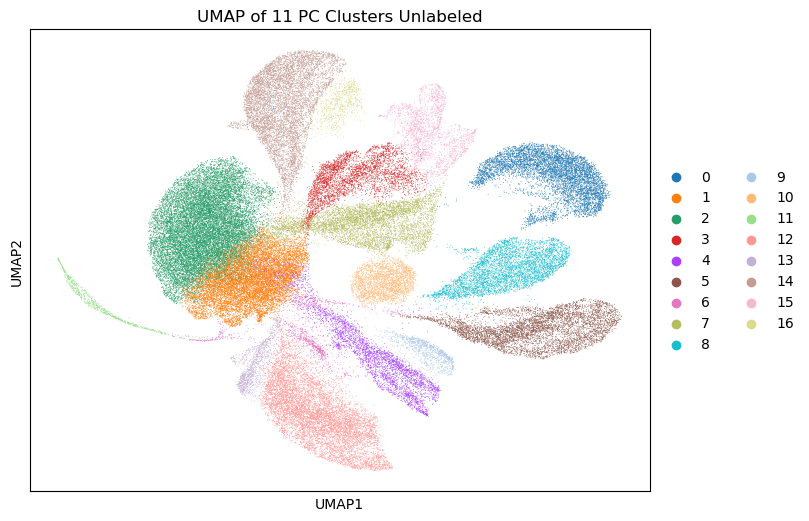

In [47]:
#cluster highly variable features
print('Clustering data and creating UMAP...')
adata = processing.cluster_data(adata, n_neighbors, n_pcs, resolution, min_dist, spread, display_UMAP_unlabeled)

After performing clustering using KNN with the leiden algorithm and displaying the UMAPs above, we can see the general cellular spatial relationships that make up this dataset. The top UMAP displays cellular relationships distibuted across each subtype. Across all subtypes, we can see a large cluster of cells to the center-left of the plot, indicating that those cells are equally present across all cancer types. However, as we move right across the UMAP landscape, we can begin to see subtype-specific clusters form, which are entirely composed of a specific cell type for each specific cancer type.

The following UMAP depcits specific cell type clusters and are labeled with numbers 0-16, indicating 17 total distinct cell types that are present in our dataset. In order to identify what these clusters are cell wise, a differential feature expression analysis is performed to identify what markers are most significantly expressed.

__C) Differential Feature Expression analysis:__

Finding differentially expressed features...
Top differentially expressed markers for PC 0:
   Marker       Score  p-value
0     VWF  113.114258      0.0
1   RAMP3   99.133263      0.0
2   CLDN5   93.451172      0.0
3  CALCRL   90.220947      0.0
4   ACKR1   82.648369      0.0
5    RBP7   81.505150      0.0
6    SDPR   78.242302      0.0
7   FABP4   78.006264      0.0
8   HYAL2   73.984337      0.0
9  TSPAN7   70.745087      0.0
Top differentially expressed markers for PC 1:
     Marker      Score        p-value
0    GPR171  23.714640  2.546817e-124
1    CD40LG  19.850742   1.085862e-87
2     PLAC8  15.241188   1.884136e-52
3     IGLC2  11.689125   1.448719e-31
4     TRGC2   8.862808   7.802349e-19
5      IGKC   6.826818   8.681839e-12
6     CTLA4   5.219954   1.789676e-07
7  SCGB1B2P   4.658846   3.179873e-06
8       TNF   4.477693   7.545421e-06
9     CCL20   3.494806   4.744074e-04
Top differentially expressed markers for PC 2:
          Marker      Score        p-value
0           

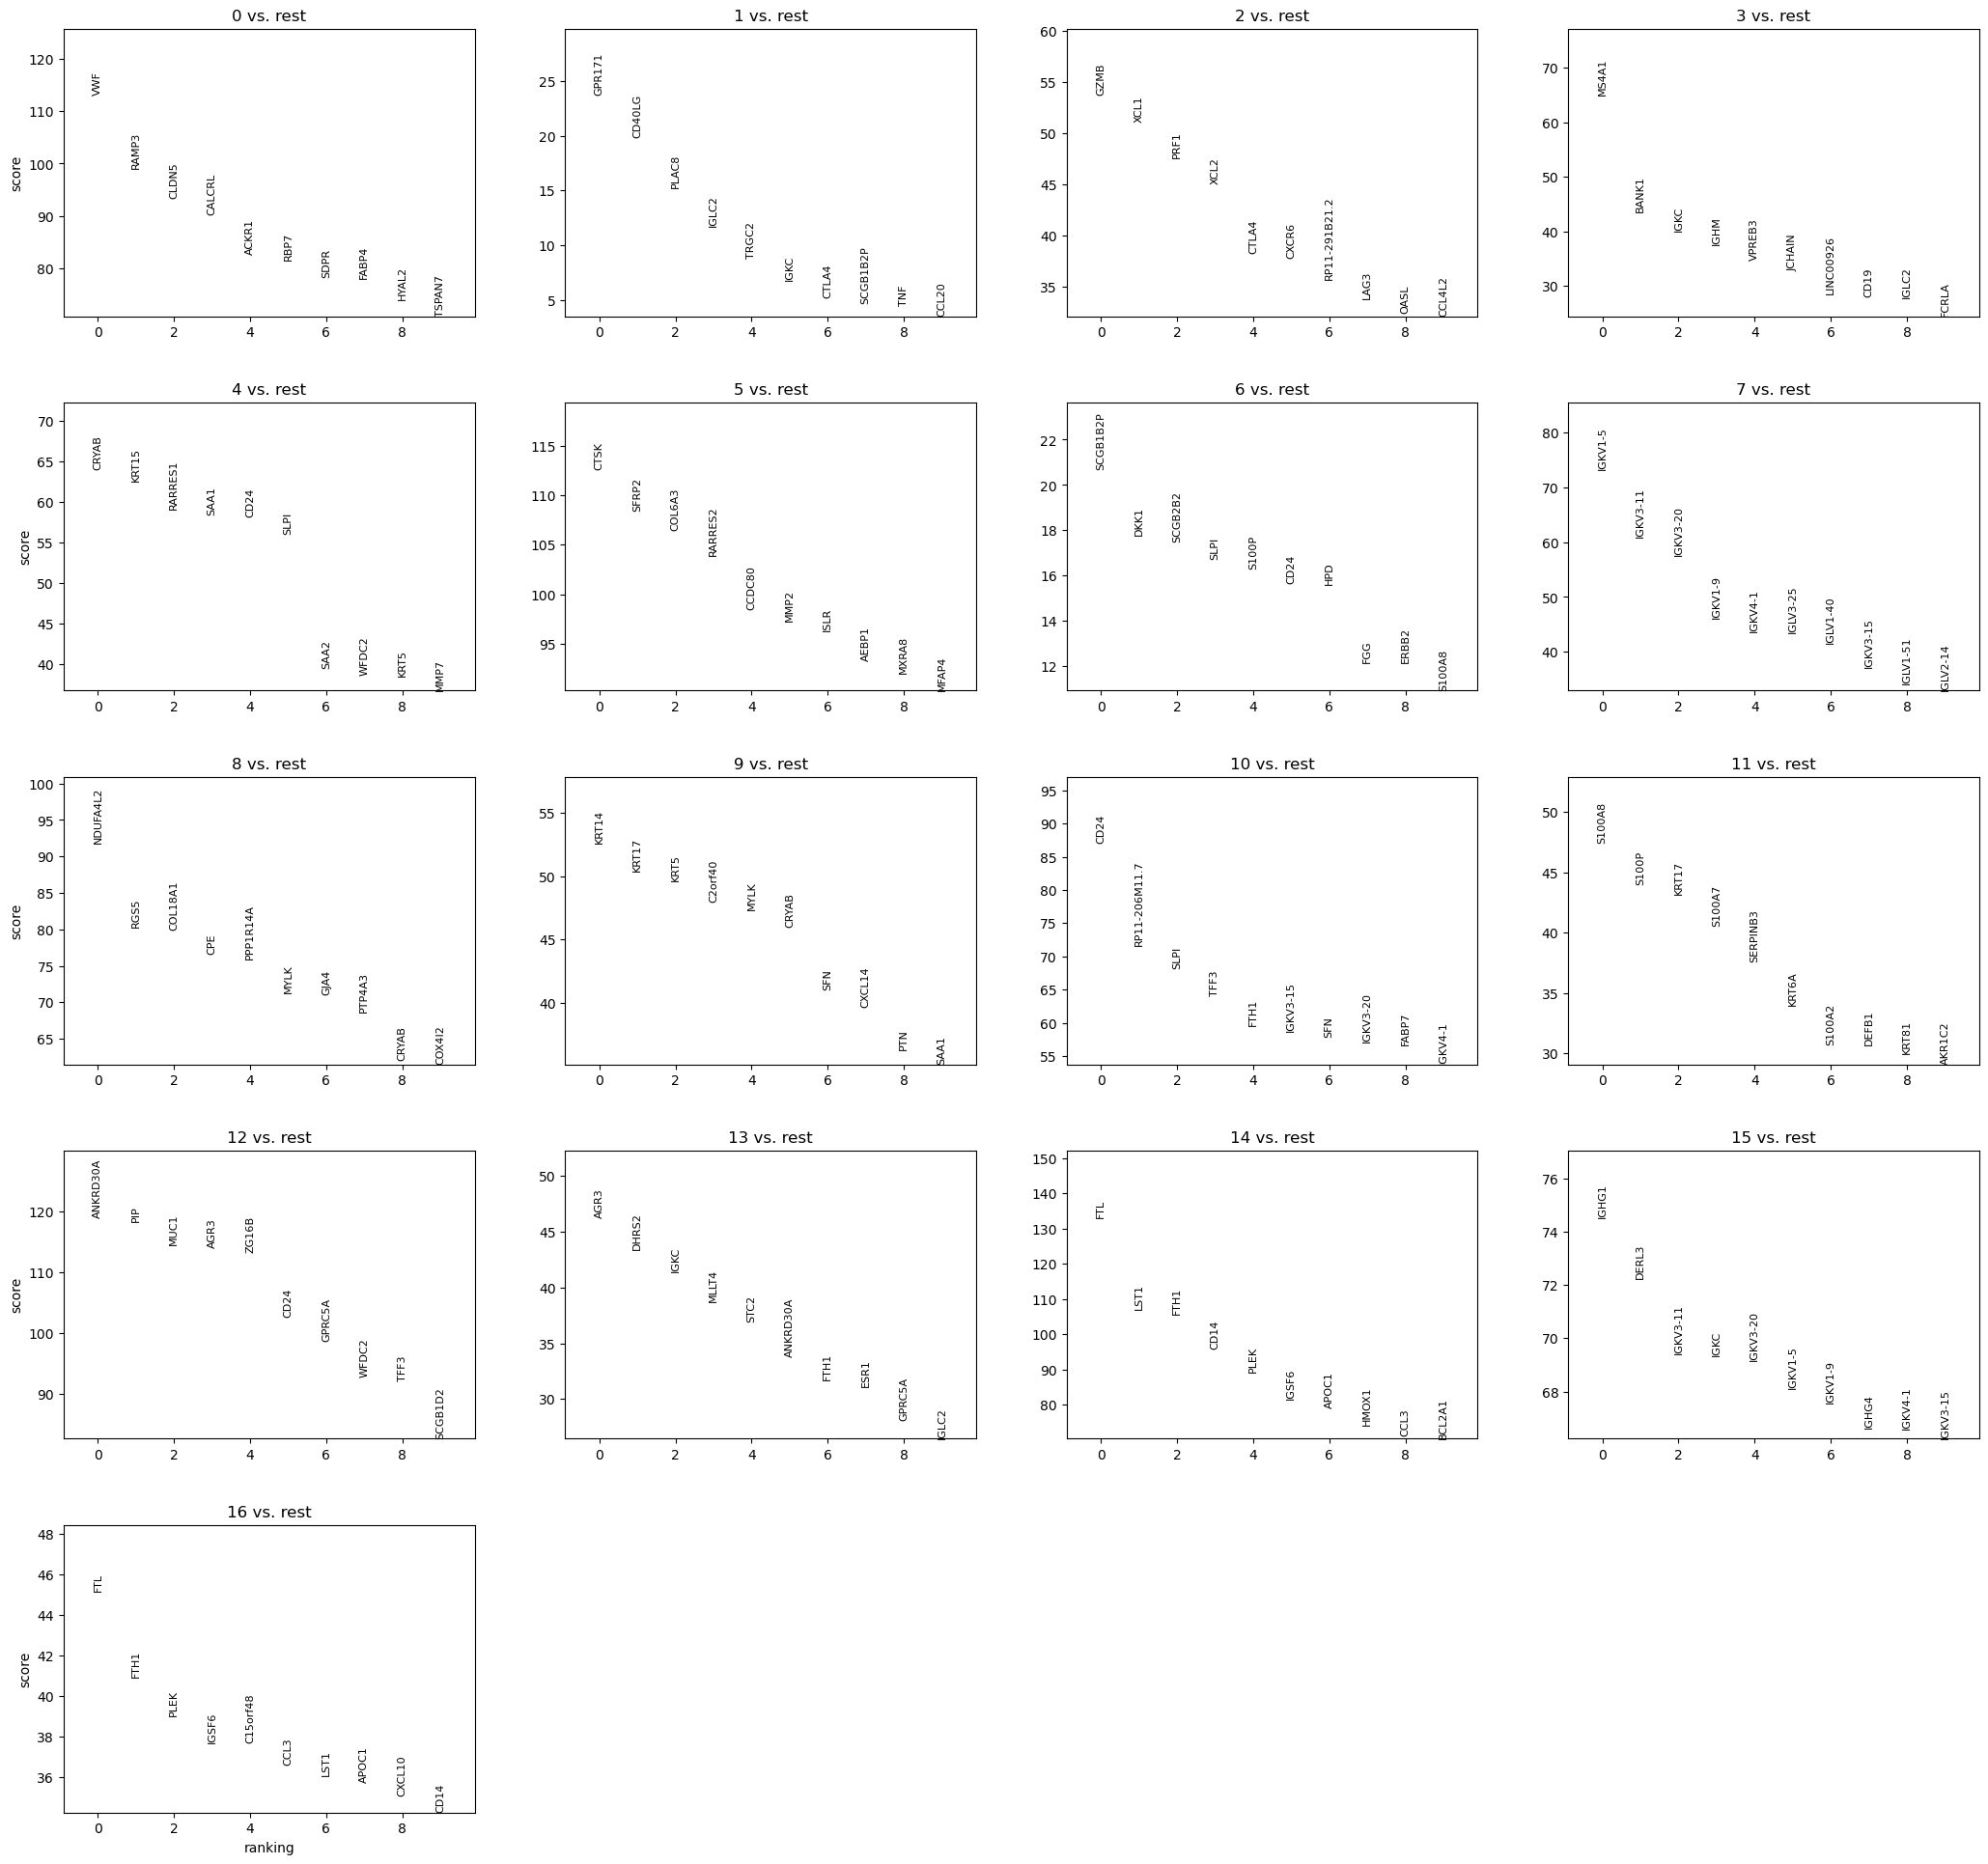

In [48]:
#find differentially expressed features
print("Finding differentially expressed features...")
adata, all_DEFs = processing.find_DEFs(adata, n_genes)

Of the plots above, we can see the top 10 features/markers that define each PC, which correspond to a specific ell type. For example, PC 0 (shown in the top left) reveals that on average, all of the cells present in PC 0 are defined by the overexpression of the marker VWF. By cross checking what this marker/gene encodes for using online databases, we can confidently label and identify the cells in our dataset.

__3) Postprocessing:__

With our data clustered and having identified differentially expressed features that define each cluster of cells, we can begin to label these groups by their most prevalent markers. For this analysis, all cluster identifications were made by cross-referencing differentially expressed features with their single-cell identifications from [The Human Protein Atlas](https://www.proteinatlas.org/).

__A) UMAP labeling:__

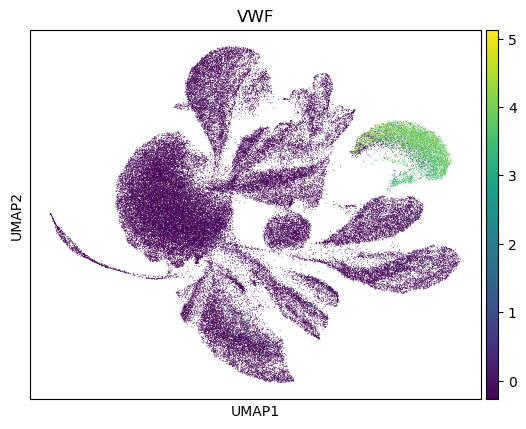

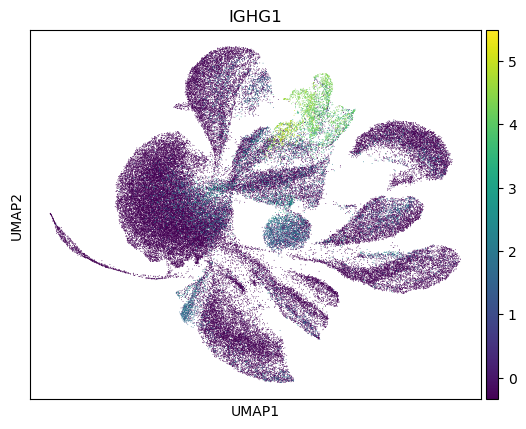

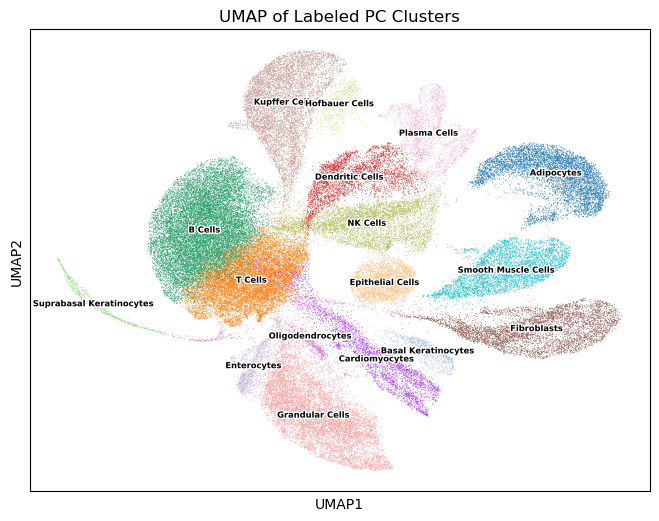

In [50]:
#plot marker-specific umaps and label umap with cell types
adata = postprocessing.umap_labels(adata, all_DEFs)

Using the marker search function added in the postprocessing step, we can visualize the distribution of specific markers across the different subtypes. For example, we can see that the marker VWF which dominates and defines PC 0, is almost solely contained to this PC. On the other hand, a marker such as IGHG1 primarily defines PC 15, but can also sparsely be found in clusters 10 and 13, indicating a potential relationship or similarity between the clusters and thus the cell types as well. 

Repeating this process for each PC reveals a complete cellular landscape and the labeling of each cluster. As expected, we can see that the largest cluster of cells in this dataset is composed of B and T cells, as well as other immune cells including NK cells, dendritic cells, and plasma cells. 

Comparing these UMAPs to the one in 'Processing - Section B', we can identify cell population disparities between the cancer subtypes and further revealing potential diagnostic biomarker potential. For example, we can see an abundance of NK cells which directly overlap with being solely present in the TNBC sample. These findings align with the conclusions drawn from the [American Cancer Society](https://www.cancer.org/research/acs-research-highlights/breast-cancer-research-highlights/treatment-and-reducing-metastasis-studies-breast-cancer/some-natural-killer-cells-aid-and-abet-triple-negative-breast-cancer.html#:~:text=Study%20of%20TNBC%20human%20tissue%20samples.&text=The%20TNBC%20tumor%20microenvironment%20had,overall%20survival%20rate%20for%20TNBC.), which highlights that the TNBC tumor microenvironment has a higher number of immature subset of NK cells compared to the number in non-TNBC (ER+/PR+) patient samples, and further propogates the lower overall survival rate for TNBC. 

Overall, This project aims to elucidate breast cancer subtype-specific biomarkers that have the potential to be utilized as diagnostic targets, and is supported by previous literature. 